In [29]:
import os
import glob as glob
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA, IncrementalPCA
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from scipy.interpolate import interp1d
import statsmodels.api as sm 
import statsmodels
import matplotlib.pyplot as plt
%matplotlib inline  
import supereeg as se

# from helpers import isfc, wisfc, mean_combine, corrmean_combine

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
def reduce_list(x, model):
    split = np.cumsum([len(xi) for xi in x])[:-1]
    x_r = np.vsplit(model.fit_transform(np.vstack(x)), split)
    if len(x) > 1:
        return [xi for xi in x_r]
    else:
        return [x_r[0]]

In [30]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [112]:
def norm_vals(vals):
    return (vals-vals.min())/(vals.max() - vals.min())

In [31]:
def n_derivative(arr, degree=1):
    """Compute the n-th derivative."""
    result = arr.copy()
    for i in range(degree):
        result = np.gradient(result)
    return result


def close_zero(arr, threshold=1e-4):
    return (abs(arr) < threshold)

def maxima_2(arr):
    
    
    bl = close_zero(n_derivative(arr, 2))
    b2 = close_zero(n_derivative(arr, 3))

    try_it = bl & b2 & (n_derivative(arr, 3) > 0)
    
    for i, e in reversed(list(enumerate(try_it))):

        if e == False:
            k = i
            break
            
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-4)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-5)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break
                
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-6)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break 
                
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-7)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break  
                
    return k


In [7]:
# datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [8]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [9]:
# nii_bo_dir = '../../data/niis'

In [10]:
# pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
# if not os.path.exists(pca_nii_bo_dir):
#     os.makedirs(pca_nii_bo_dir)

In [11]:
# neurosynth_dir ='../figs/neurosynth_data/'
# if not os.path.exists(neurosynth_dir):
#     os.mkdir(neurosynth_dir)

In [12]:
# n_f_dir = os.path.join(neurosynth_dir, 'figs')
# if not os.path.exists(n_f_dir):
#     os.mkdir(n_f_dir)
# nii_dir = os.path.join(neurosynth_dir, 'niis')
# if not os.path.exists(nii_dir):
#     os.mkdir(nii_dir)
# txt_dir = os.path.join(neurosynth_dir, 'txts')
# if not os.path.exists(txt_dir):
#     os.mkdir(txt_dir)
# p_txt_dir = os.path.join(txt_dir, 'parsed_txts')
# if not os.path.exists(p_txt_dir):
#     os.mkdir(p_txt_dir)

In [13]:
ddir = '../../data/'

In [14]:
results_dir = os.path.join(ddir, 'results')
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [15]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [16]:
template = se.helpers._gray(res=2)

In [17]:
factors=700

In [18]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [19]:
pieman_data = loadmat(pieman_name)

In [20]:
debug = False

In [21]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [22]:
data = np.array(data)
conds = np.array(conds)

## pieman pca decoding

In [10]:
resultsdir = '/Users/lucyowen/repos/pca_paper-1/results/pca_decode/PCA/ndims_700'

In [11]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [12]:
conds

['/Users/lucyowen/repos/pca_paper-1/results/pca_decode/PCA/ndims_700/rest.csv',
 '/Users/lucyowen/repos/pca_paper-1/results/pca_decode/PCA/ndims_700/word.csv',
 '/Users/lucyowen/repos/pca_paper-1/results/pca_decode/PCA/ndims_700/intact.csv',
 '/Users/lucyowen/repos/pca_paper-1/results/pca_decode/PCA/ndims_700/paragraph.csv']

In [13]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [14]:
full_data.head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.691675,0.0000,0.484556,1,0,1,rest
1,0,0.464944,0.0000,0.351287,2,0,1,rest
2,0,0.489600,0.0000,0.322356,3,0,1,rest
3,0,0.492381,0.0025,0.332581,4,0,1,rest
4,0,0.495806,0.0000,0.336725,5,0,1,rest


In [15]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.718644,0.006667,0.487556,1,0,1,intact
1,0,0.584044,0.006667,0.329167,2,0,1,intact
2,0,0.598544,0.006667,0.333278,3,0,1,intact
3,0,0.632989,0.003333,0.334367,4,0,1,intact
4,0,0.653056,0.010000,0.312944,5,0,1,intact


In [16]:
# outfile = os.path.join(figdir, 'Accuracy_by_components.pdf')
outfile = None

AttributeError: 'NoneType' object has no attribute 'write'

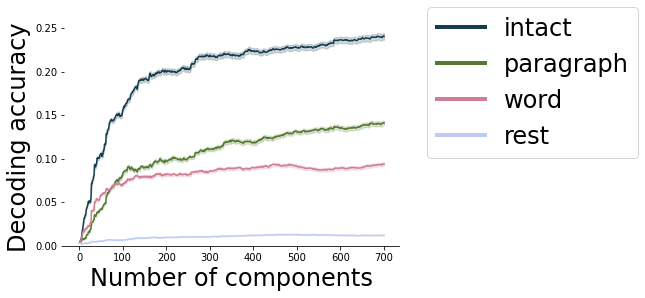

In [18]:
fig, ax = plt.subplots()
sns.lineplot(x="dims", y="accuracy",
             hue="condition",
             data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
#ax.set_title('Accuracy by components')
ax.set_ylabel('Decoding accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.set_ylim(0, .25)
# ax.hlines(y=.05, xmin=0, xmax=100, linewidth=1, color='black')
# ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
#ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')

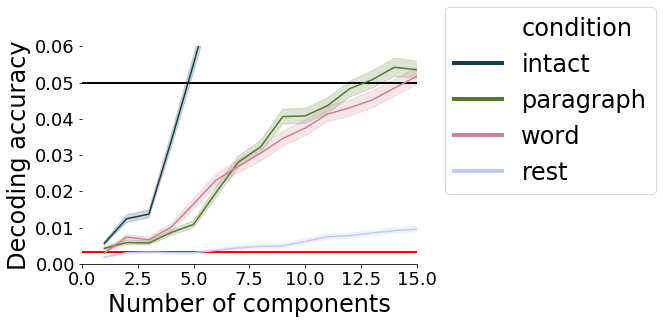

In [182]:
outfile = os.path.join(figdir, 'Accuracy_by_components_zoomed.pdf')
fig, ax = plt.subplots()
sns.lineplot(x="dims", y="accuracy",
             hue="condition",
             data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
#ax.set_title('Accuracy by components')
ax.set_ylabel('Decoding accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.set_ylim(0, .06)
ax.set_xlim(0, 15)
ax.hlines(y=.05, xmin=0, xmax=15, linewidth=2, color='black')
ax.hlines(y=1/300, xmin=0, xmax=20, linewidth=2, color='r')
#ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')

In [19]:
resultsdir = '/Users/lucyowen/repos/pca_paper-1/results/pca_decode_chunked/PCA/ndims_700'

In [20]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [21]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [22]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,third,condition
0,0.0,0.7954,0.02,0.4859,1.0,0.0,0.0,0.0,intact
1,0.0,0.5700,0.02,0.3726,2.0,0.0,0.0,0.0,intact
2,0.0,0.6461,0.03,0.3310,3.0,0.0,0.0,0.0,intact
3,0.0,0.6229,0.01,0.3121,4.0,0.0,0.0,0.0,intact
4,0.0,0.6148,0.01,0.2975,5.0,0.0,0.0,0.0,intact


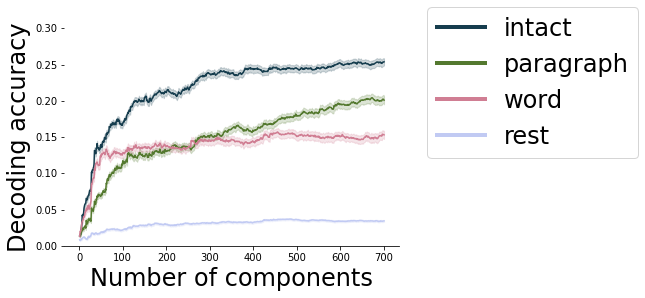

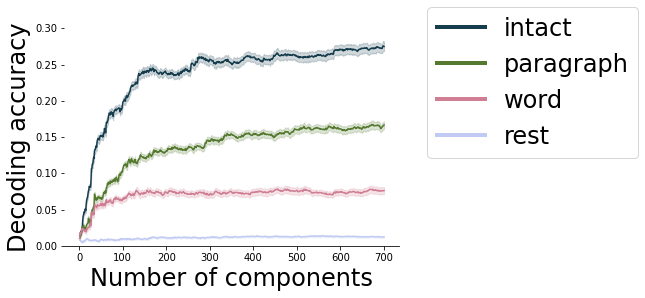

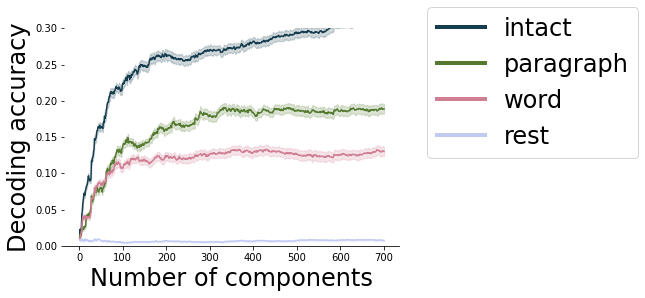

In [27]:
for i in range(3):
    #outfile = os.path.join(figdir, 'Accuracy_by_components_third_' + str(i) + '.pdf')
    outfile = None
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .3)
    #ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    plt.show()
    #fig.savefig(outfile, bbox_inches='tight')
    

In [38]:
full_data.

AttributeError: 'DataFrame' object has no attribute 'isinf'

In [32]:
data_regression = full_data.groupby(['iteration', 'folds', 'condition', 'dims'], 
                           group_keys=False).apply(regress, 'accuracy', ['third']).reset_index()

MissingDataError: exog contains inf or nans

In [ ]:
#outfile = os.path.join(figdir, 'Changes_across_thirds.pdf')

outfile = None

fig, ax = plt.subplots()
sns.lineplot(x="dims", y="third",
             hue="condition",
             data=data_regression, palette="cubehelix", 
           hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
#ax.set_title('Accuracy by components for third: ' + str(i + 1))
ax.set_ylabel('Change in accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)

l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
plt.show()
#fig.savefig(outfile, bbox_inches='tight')

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


25
21
19
8


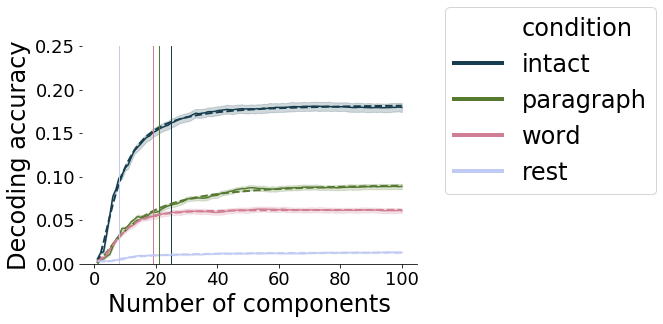

In [153]:
outfile = os.path.join(figdir, 'Acc_dims.pdf')

resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100'

fig, ax = plt.subplots()
sns.lineplot(x="dims", y="accuracy",
             hue="condition",
             data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
#ax.set_title('Accuracy by components')
ax.set_ylabel('Decoding accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.set_ylim(0, .25)
l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)


conditions = ['intact', 'paragraph', 'word', 'rest']

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))


for e, c in enumerate(conditions):


    ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)


    f = interp1d(xdata, func(xdata, *popt), 'cubic')
    y = f(xdata)

    hill_all[e, 0] = maxima_2(y)

    maxs_all[e, 0] = func(maxima_2(y), *popt)
    print(maxima_2(y))
    plt.plot(xdata, func(xdata, *popt),color=colors[e], linestyle='--', linewidth=2)
    plt.axvline(x=maxima_2(y), color=colors[e], linewidth=1)
    
fig.savefig(outfile, bbox_inches='tight')

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
No handles with labels found to put in legend.


25
21
19
8


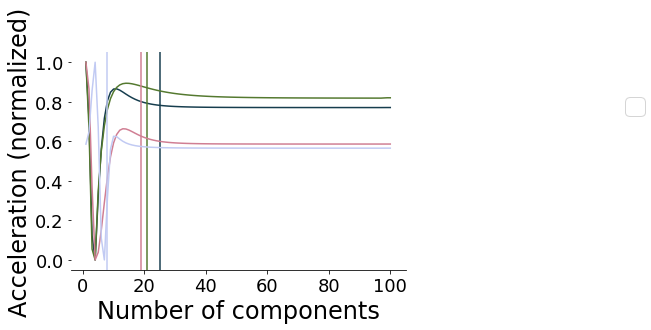

In [154]:
def func(x, a, b, c, d, g):

    return (((a-d)/((1+((x/c)** b))**g)) + d )


outfile = os.path.join(figdir, 'Acc_dims_second_deriv.pdf')

fig, ax = plt.subplots()


    
maxs_ns = np.zeros((1, 4, 4))
hills_ns = np.zeros((1, 4, 4))

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))


resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100'

conds =glob.glob(os.path.join(resultsdir, '*.csv'))
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)


conditions = ['intact', 'paragraph', 'word', 'rest']

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))


for e, c in enumerate(conditions):


    ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)


    f = interp1d(xdata, func(xdata, *popt), 'cubic')
    y = f(xdata)

    hill_all[e, 0] = maxima_2(y)

    maxs_all[e, 0] = func(maxima_2(y), *popt)

    
    #norm_vals(n_derivative(y, 3))
    plt.plot(xdata, norm_vals(n_derivative(y, 3)), color=colors[e])
    print(maxima_2(y))
    plt.axvline(x=maxima_2(y), color=colors[e], linestyle='-')

sns.despine(ax=ax, left=True)
#ax.set_title('Accuracy by components')
ax.set_ylabel('Acceleration (normalized)',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
#ax.set_ylim(0, .25)
l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
plt.show()

fig.savefig(outfile, bbox_inches='tight')

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


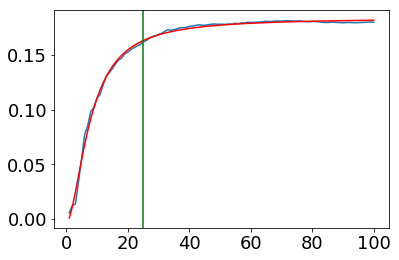

25
intact
0


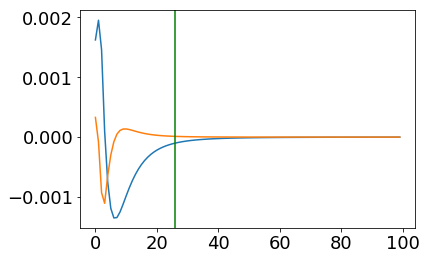

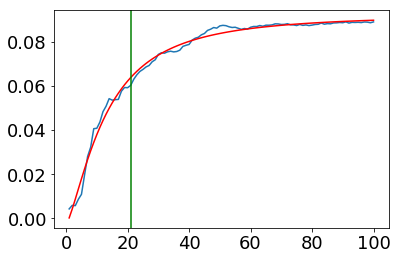

21
paragraph
0


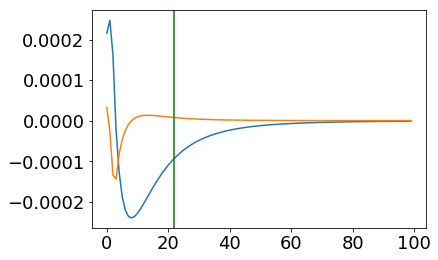

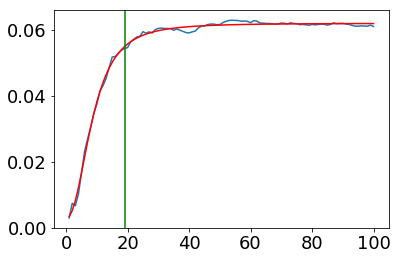

19
word
0


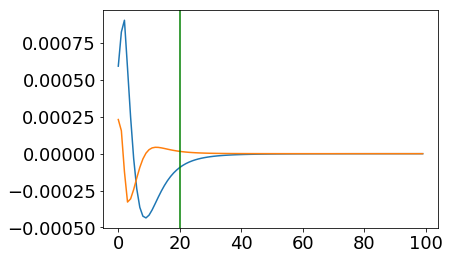

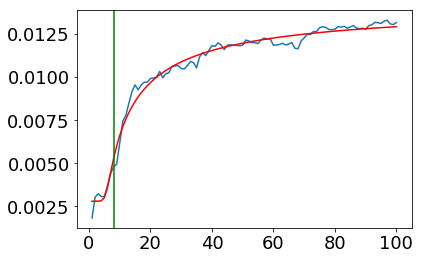

8
rest
0


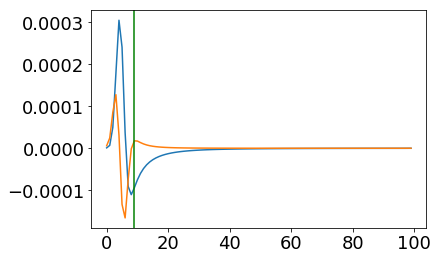

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


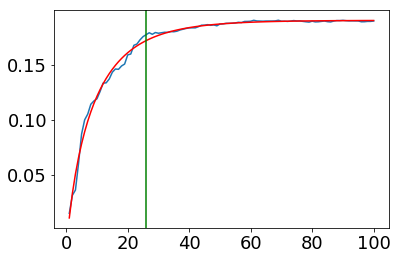

26
intact
1


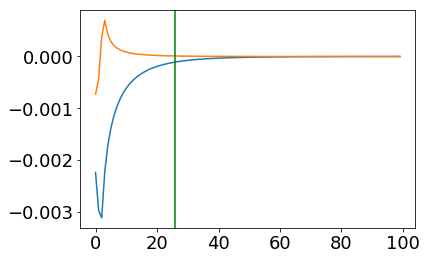

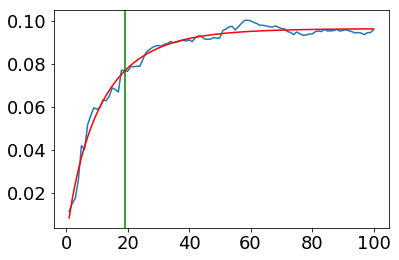

19
paragraph
1


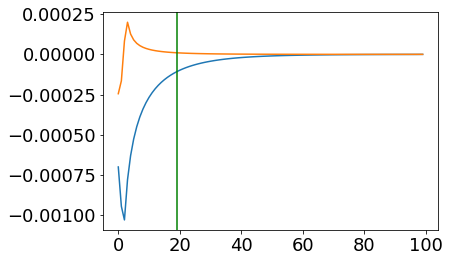

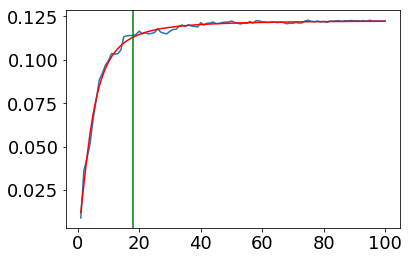

18
word
1


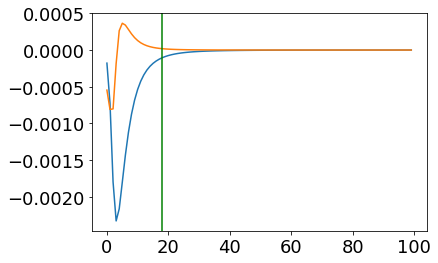

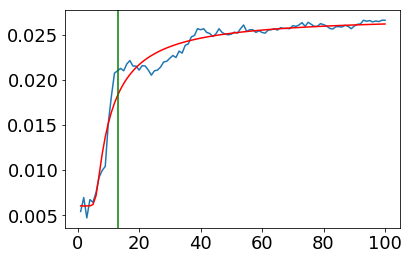

13
rest
1


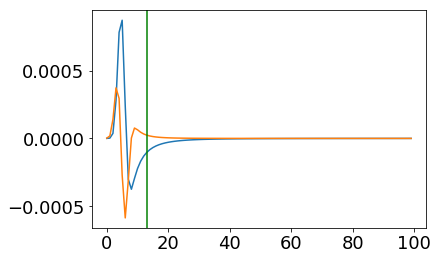

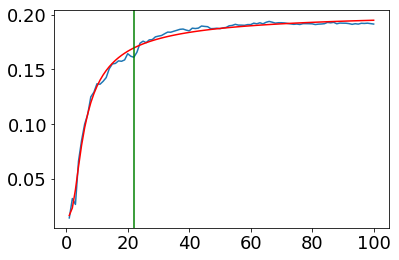

22
intact
2


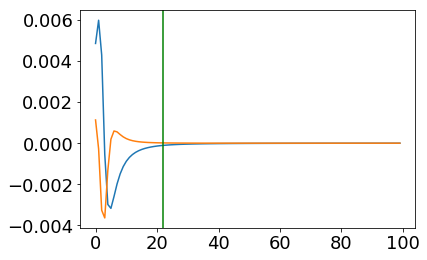

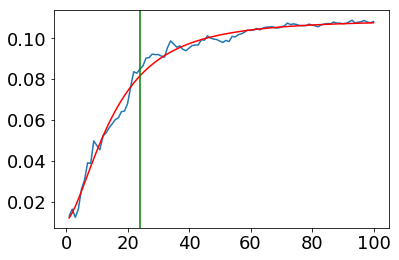

24
paragraph
2


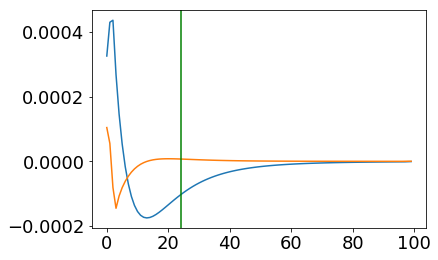

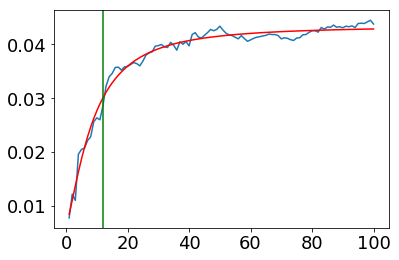

12
word
2


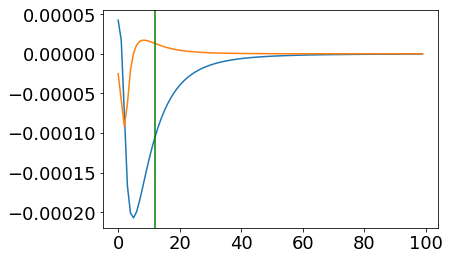

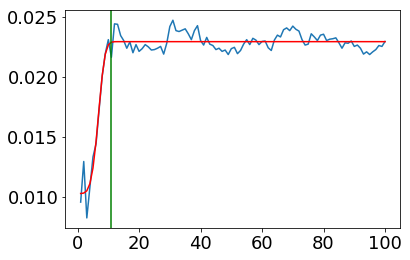

11
rest
2


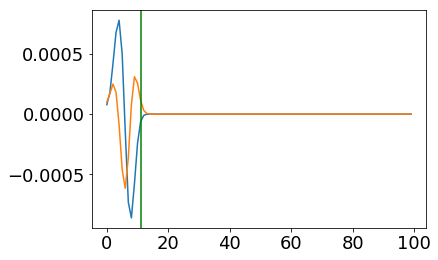

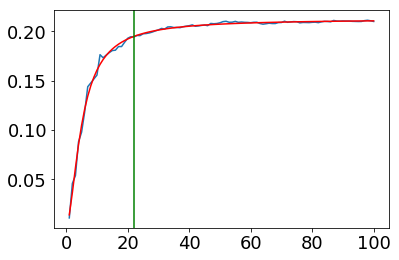

22
intact
3


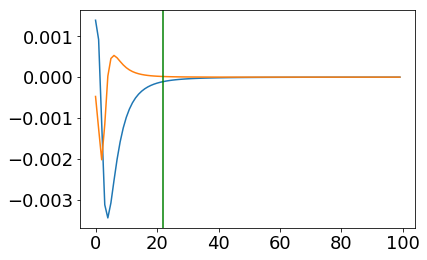

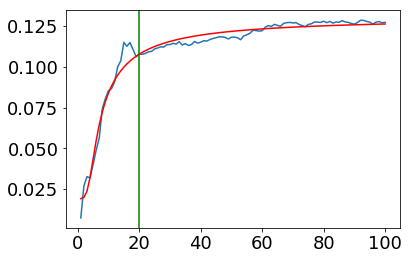

20
paragraph
3


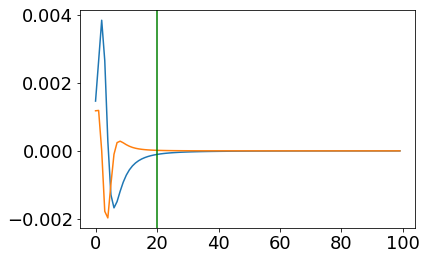

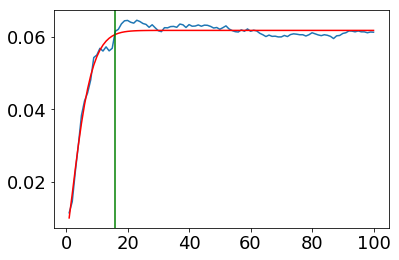

16
word
3


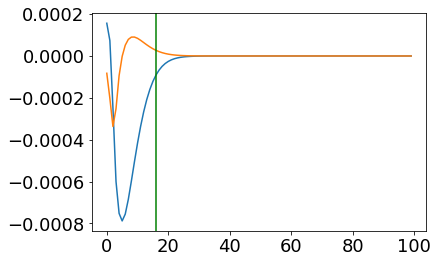

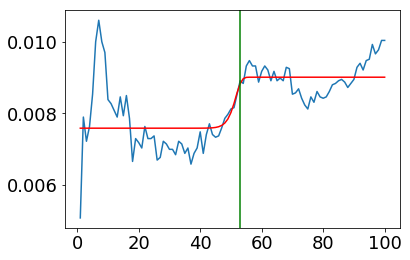

53
rest
3


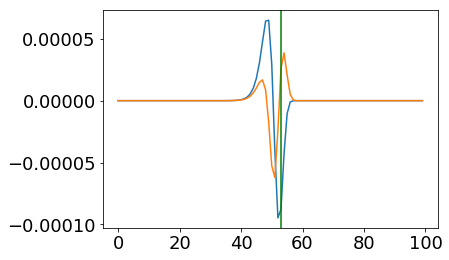

In [155]:

def func(x, a, b, c, d, g):

    return (((a-d)/((1+((x/c)** b))**g)) + d )


maxs_ns = np.zeros((1, 4, 4))
hills_ns = np.zeros((1, 4, 4))

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))


resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100'

conds =glob.glob(os.path.join(resultsdir, '*.csv'))
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)


conditions = ['intact', 'paragraph', 'word', 'rest']

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))


for e, c in enumerate(conditions):


    ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)


    f = interp1d(xdata, func(xdata, *popt), 'cubic')
    y = f(xdata)

    hill_all[e, 0] = maxima_2(y)

    maxs_all[e, 0] = func(maxima_2(y), *popt)

    plt.plot(xdata, ydata)
    plt.plot(xdata, func(xdata, *popt), 'r-')
    plt.axvline(x=maxima_2(y), color='g', linestyle='-')
    plt.show()

    print(maxima_2(y))
    print(c)
    print(i)
    plt.plot(n_derivative(y, 2))
    plt.plot(n_derivative(y, 3))
    plt.axvline(x=xdata[maxima_2(y)].min(), color='g', linestyle='-')
    plt.show()

resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_chunked/PCA/ndims_100'
conds =glob.glob(os.path.join(resultsdir, '*.csv'))
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

conditions = ['intact', 'paragraph', 'word', 'rest']

for i in np.arange(1, 4):

    full_data_temp = full_data[full_data['third']==i-1]

    for e, c in enumerate(conditions):


        ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=1000000)

        f = interp1d(xdata, func(xdata, *popt), 'cubic')
        y = f(xdata)

        hill_all[e, i] = maxima_2(y)

        maxs_all[e, i] = func(maxima_2(y), *popt)

        plt.plot(xdata, ydata)
        plt.plot(xdata, func(xdata, *popt), 'r-')
        plt.axvline(x=maxima_2(y), color='g', linestyle='-')
        plt.show()

        print(maxima_2(y))
        print(c)
        print(i)
        plt.plot(n_derivative(y, 2))
        plt.plot(n_derivative(y, 3))

        plt.axvline(x=maxima_2(y), color='g', linestyle='-')
        plt.show()

hills_ns[0, :, :] = hill_all

maxs_ns[0, :, :] = maxs_all

In [156]:
outfile = os.path.join(results_dir, 'accuracy.npz')
np.savez(outfile, hills=hills_ns, maxs=maxs_ns)

In [157]:
# outfile = os.path.join(figdir, 'Changes_across_thirds.pdf')

# fig, ax = plt.subplots()
# sns.lineplot(x="dims", y="third",
#              hue="condition",
#              data=data_regression, palette="cubehelix", 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
# sns.despine(ax=ax, left=True)
# #ax.set_title('Accuracy by components for third: ' + str(i + 1))
# ax.set_ylabel('Change in accuracy',fontsize=24)
# ax.set_xlabel('Number of components',fontsize=24)

# l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
# for line in l.get_lines():
#     line.set_linewidth(4.0)
# fig.savefig(outfile, bbox_inches='tight')

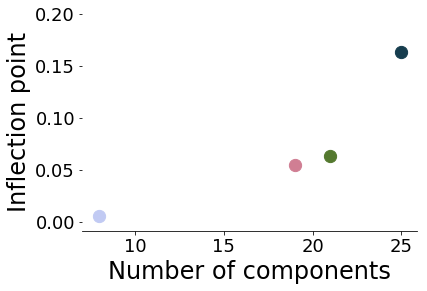

In [158]:
outfile = os.path.join(figdir, 'Acc_dims_explaination.pdf')

fig = plt.figure()
sns.despine(ax=ax, left=True)
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    for i in np.arange(1):
        plt.scatter(hills_ns[0, e, i],maxs_ns[0, e, i], 
                    marker=markers[i], s=150, color=colors[e])
ax.set_ylabel('Inflection point',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig(outfile, bbox_inches='tight')

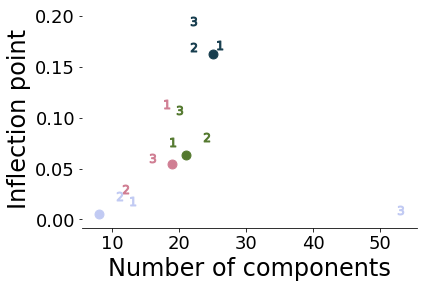

In [159]:
outfile = os.path.join(figdir, 'Acc_dims_across_thirds.pdf')

fig = plt.figure()
sns.despine(ax=ax, left=True)
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    for i in np.arange(4):
        plt.scatter(hills_ns[0, e, i],maxs_ns[0, e, i], 
                    marker=markers[i], s=80, color=colors[e])
ax.set_ylabel('Inflection point',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig(outfile, bbox_inches='tight')